In [222]:
import pandas as pd
import numpy as np
import matplotlib as plt
from mlxtend.frequent_patterns import apriori, association_rules

In [223]:
sampleData = pd.read_csv('sample3Solostove.csv')

In [224]:
sampleData.describe()

,order_id,items_total
count,5.000000e+05,500000.000000
mean,1.223516e+06,2.921776
std,6.350240e+04,1.551330
min,1.107551e+06,1.000000
25%,1.167827e+06,2.000000
50%,1.228765e+06,3.000000
75%,1.278982e+06,3.000000
max,1.329221e+06,100.000000


In [225]:
def sale_remove(name):
    return name.rpartition(' (')[0]
def extra_space_remove(name):
    return name[:-1]

In [226]:
# Removes shipping insurance rows
sampleData = sampleData[sampleData['name'] != 'Route Shipping Insurance']
# Removes rows with damage
sampleData = sampleData[sampleData['name'].str.contains('Dented') == False]
# Simplifies gift card rows to one product type
sampleData.loc[sampleData['name'].str.contains('Gift'),'name'] = 'Gift Card'
# Removes shipping dates
sampleData.loc[sampleData['name'].str.contains(' \('),'name'] = sampleData.loc[sampleData['name'].str.contains(' \('),'name'].apply(sale_remove)
# Removes extra spaces
sampleData.loc[sampleData['name'].str[-1] == ' ', 'name'] = sampleData.loc[sampleData['name'].str[-1] == ' ', 'name'].apply(extra_space_remove)

In [228]:
numBought = sampleData['name'].value_counts()

<AxesSubplot:>

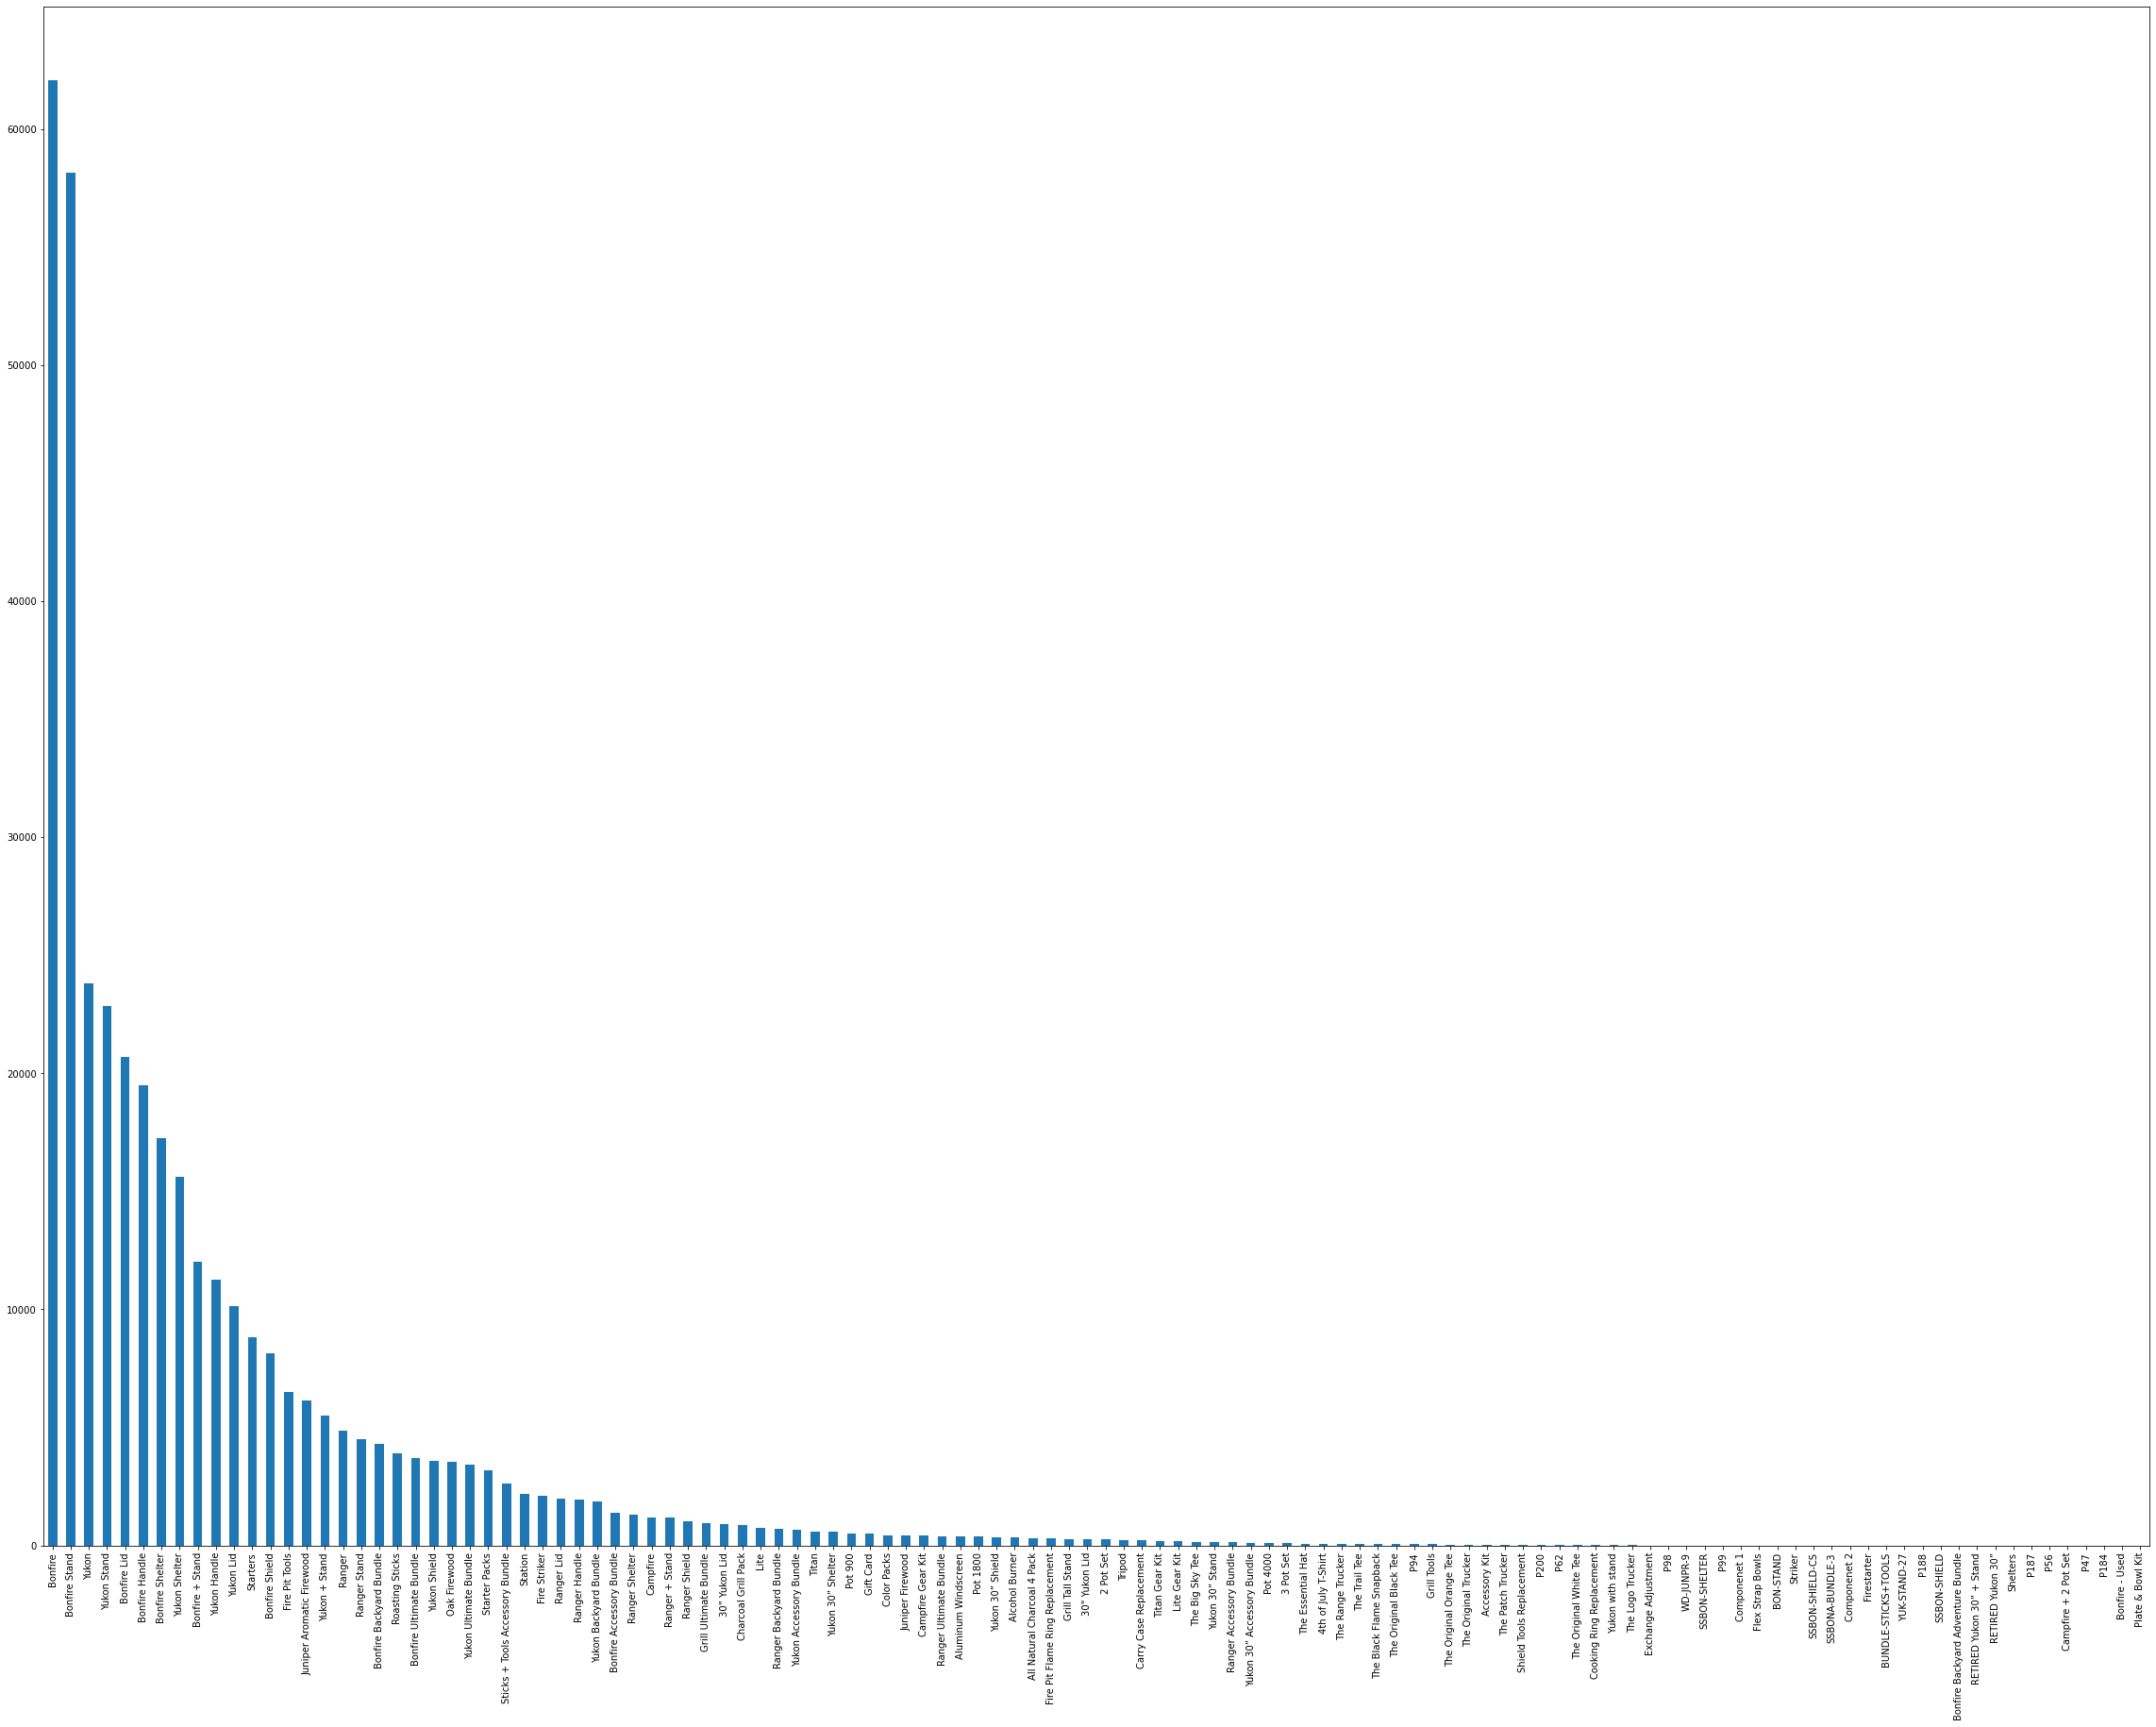

In [230]:
numBought.plot(kind='bar', figsize=(40, 30))

In [231]:
def market_basket_analysis(data, id_num, name):
    """
    Performs market basket analysis on the given dataset, outputing the most common combinations of products bought.
    Inputs: 
    
    data -> Pandas DataFrame with following form.
        Cols: id_num, name
        Rows: Represent a product with name and an order_id number id_num, orders with multiple products are represented in multiple rows
    id_num -> name of column representing order id number
    name -> name of column representing product names
    
    Outputs:
    
    Tuple with two DataFrames, recommendations and frequent_itemsets
    recommendations -> Pandas DataFrame representing the products most likely to be paired with each product.
        Includes lift and support metrics
            Lift -> Measures the probability of the two items being ordered together relative to the probabilty of the two items being ordered
            Support -> Measures the probability of the two items being ordered together
            
    frequent_itemsets -> Pandas DataFrame representing the most common combinations of products ordered.
        Includes a set of the item, as well as the probability of that order and the number of items in that order.
    """
    data['bought'] = 1
    orders = data.groupby([id_num, name])['bought'].sum().unstack().reset_index().fillna(0).set_index(id_num)
    def encode_units(x):
        if x <= 0:
            return False
        if x >= 1:
            return True
    orders_binary = orders.applymap(encode_units)
    frequent_itemsets = apriori(orders_binary, min_support=0.001, use_colnames=True, max_len = 2)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
    recommended = rules.groupby(['antecedents', 'consequents'])[['lift', 'support']].first()
    recommended = recommended.sort_values(by = 'support', ascending = False).sort_index(level = 'antecedents', sort_remaining = False)
    frequent_itemsets = frequent_itemsets.sort_values(by = 'support', ascending = False)
    
    return (recommended, frequent_itemsets)

In [232]:
recommended, frequent_itemsets = market_basket_analysis(sampleData, 'order_id', 'name')

In [233]:
recommended.to_csv('solostoveAssociations.csv')

In [234]:
frequent_itemsets.to_csv('solostoveFrequent.csv')